Jupyter Python 3 notebook for reproducing figures in <i>PNAS</i> manuscript, "Growth, death, and competition in sessile organisms" by ED Lee, CP Kempes, and GB West. In order to reproduce the figures, the corresponding pickles must be generated by running the code in `pipeline.py`.

Author: Eddie Lee, edlee@santafe.edu

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', size=20)

In [3]:
# import necessary standard Python modules
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.image import imread
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# import custom Python modules
from misc.plot import colorcycle  # see installation instructions
from pyutils import *

# set image save path
imgdr = os.path.expanduser('~') + '/Dropbox/Research/forests/writing/20201130_pnas'
assert os.path.isdir(imgdr), "Directory in which to save images does not exist."

# Figure 2

In [134]:
load_pickle('cache/biomass_scaling_w_compet_nu=2.5.p.bak')

['nk', 't', 'rk', 'forest', 'r0', 'g0', 'nu', 'Abar', 'basalRange', 'cg', 'dt']

In [137]:
load_pickle('plotting/biomass_scaling_w_compet_nu=2.5.p')

['forest']

In [57]:
beta = .0125

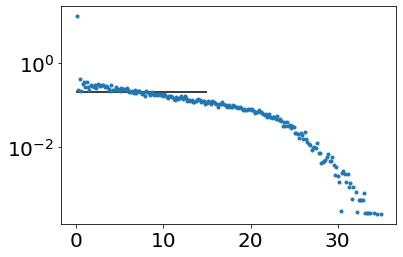

In [58]:
# small trees
xy = vstack([t.xy for t in forest[beta].trees if 5<=t.size_ix<=8])
c, r = nn.pair_correlation(xy, bounding_box=[0, 0, 200, 200])

fig, ax = plt.subplots()
ax.semilogy(r, c/r, '.')
ax.hlines(.2, 0,15)

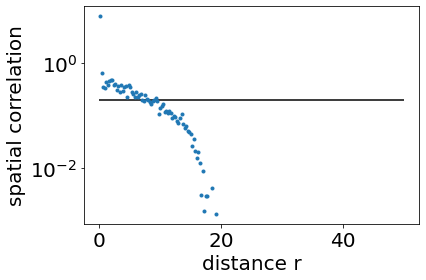

In [63]:
# big trees
xy = vstack([t.xy for t in forest[beta].trees if 15<=t.size_ix<=18])
c, r = nn.pair_correlation(xy, bounding_box=[0, 0, 200, 200])

fig, ax = plt.subplots()
ax.semilogy(r, c/r, '.')
ax.set(xlabel='distance r', ylabel='spatial correlation')
ax.hlines(.2, 0,50)

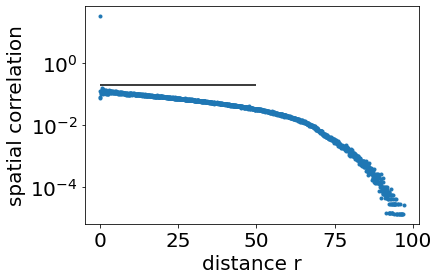

In [62]:
# all trees
xy = vstack([t.xy for t in forest[beta].trees])
c, r = nn.pair_correlation(xy, bounding_box=[0, 0, 200, 200])

fig, ax = plt.subplots()
ax.semilogy(r, c/r, '.')
ax.set(xlabel='distance r', ylabel='spatial correlation')
ax.hlines(.2, 0,50)

In [68]:
from pyutils.grow_sim import overlap_area
from itertools import chain

In [75]:
rRange = np.linspace(r0, 400, 2000)

# sizes classes of direct competitors
overlap_class = []
for i, t in enumerate(forest[beta].trees):
    overlap_class.append([t.size_ix, []])
    for j, tp in enumerate(forest[beta].trees):
        if i!=j:
            d = np.linalg.norm(t.xy-tp.xy)
            if overlap_area(d,
                            np.sqrt(1 / np.pi) * rRange[t.size_ix]**(2/3),
                            np.sqrt(1 / np.pi) * rRange[tp.size_ix]**(2/3)):
                overlap_class[-1][1].append(tp.size_ix)

_overlap_class = {}
for this_size_ix in np.unique([i[0] for i in overlap_class]):
    _overlap_class[this_size_ix] = list(chain.from_iterable([i[1]
                                                             for i in overlap_class
                                                             if i[0]==this_size_ix]))
overlap_class = _overlap_class

In [83]:
r_from_size_ix = lambda ix: np.sqrt(1 / np.pi) * rRange[ix]**(2/3)

In [127]:
rbins = np.logspace(0, np.log10(20), 20)
ix = np.digitize(r_from_size_ix(list(chain.from_iterable([overlap_class[i] for i in range(10,15)]))), rbins)

<ipython-input-128-50dc78c74d1f>:6: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogy(r_from_size_ix(np.arange(p.size, dtype=int)), p/bin_norm, '.')


[Text(0, 0.5, 'norm. freq. of neighbors'), Text(0.5, 0, 'radius')]

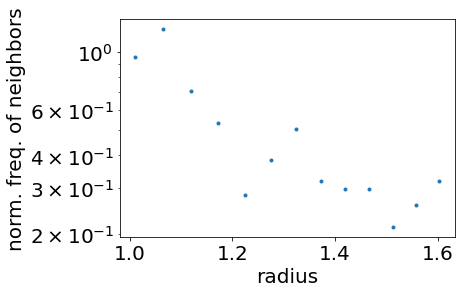

In [128]:
fig, ax = plt.subplots()

p = r_from_size_ix(np.bincount(ix))
bin_norm = np.digitize(r_from_size_ix(np.arange(400, dtype=int)), rbins)[:p.size]

ax.semilogy(r_from_size_ix(np.arange(p.size, dtype=int)), p/bin_norm, '.')
ax.set(xlabel='radius', ylabel='norm. freq. of neighbors')

Text(0.5, 0, 'plot width')

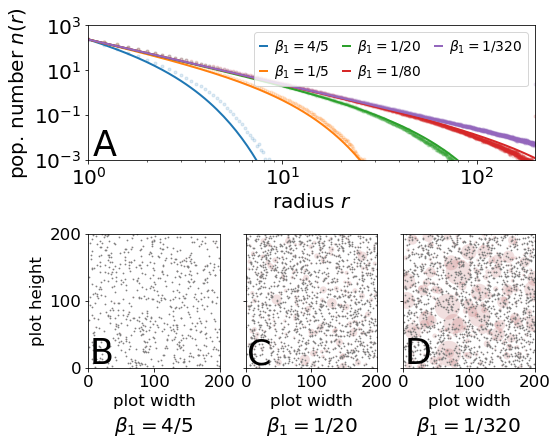

In [85]:
for k in nk.keys():
    nk[k] = np.concatenate([i[-1000:,:,None] for i in nk[k]], axis=2).mean(2)

kappa = (1.8 - 4/3) * (nu-1)
f = forest.coeffs['sharing fraction']
rhobar = forest.coeffs['resource efficiency']
cr = forest.coeffs['root']**2 * np.pi

lastn = 1000

gs = GridSpec(2, 3, hspace=.55)
fig = plt.figure(figsize=(8,6.3))
ax = fig.add_subplot(gs[0,:])

h = []
for i, (rk_, nk_) in enumerate(zip(rk.values(), nk.values())):
    h.append(ax.plot(rk_[0], nk_[-lastn:].mean(0), '.', zorder=0, alpha=.14))
    
    beta1 = basalRange[i]
    vareps = forest.coeffs['resource efficiency']
    assert nu>2
    xi0 = (nu-2)**(1/(2-nu))

    B = (beta1 * xi0 / vareps / rhobar / cr / (1-f))**(nu-1) / (nu-1)
    s = forest.coeffs['area competition']
    dx = rk_[0][1] - rk_[0][0]
    n0 = g0 / (Abar + cg/dx + dt * r0**kappa)
    
    y = (n0 * (rk_[0]/r0)**(-1/3 - Abar/cg) *
         np.exp(-B * s / cg / (kappa+2/3) * (rk_[0]**(kappa+2/3) - r0**(kappa+2/3))))
    h.append(ax.loglog(rk_[0], y, '-', lw=2, c=f'C{i}', zorder=1)[0])
    
ax.text(1.05, 1.5e-3, 'A', fontsize=35)
ax.set(xlabel=r'radius $r$',
       ylabel=r'pop. number $n(r)$',
       ylim=(1e-3, 1e3),
       xlim=(1,199))
ax.legend(h[1::2],
          [r'$\beta_1=4/5$', r'$\beta_1=1/5$', r'$\beta_1=1/20$', r'$\beta_1=1/80$', r'$\beta_1=1/320$'],
          fontsize='x-small',
          handlelength=.5, ncol=3, loc=1, columnspacing=1, handletextpad=.5)



load_pickle('plotting/biomass_scaling_w_compet_nu=2.5.p')

ax = [fig.add_subplot(gs[1,i]) for i in range(3)]
forest[basalRange[0]].plot(ax=ax[0],
                           show_canopy=False,
                           show_center=True,
                           center_kw={'c':'gray','ms':1.5})
ax[0].text(2, 6, 'B', fontsize=35)
[el.set_fontsize('small') for el in ax[0].yaxis.get_ticklabels()]
[el.set_fontsize('small') for el in ax[0].xaxis.get_ticklabels()]
ax[0].set_title(r'$\beta_1=4/5$', y=-.52, fontsize=20)
ax[0].set_xlabel('plot width', fontsize='small')
ax[0].set_ylabel('plot height', fontsize='small')
    
forest[basalRange[2]].plot(ax=ax[1],
                           show_canopy=False,
                           show_center=True,
                           center_kw={'c':'gray','ms':1.5},
                           plot_kw={'yticklabels':[]})
ax[1].text(2, 6, 'C', fontsize=35)
[el.set_fontsize('small') for el in ax[1].xaxis.get_ticklabels()]
ax[1].set_title(r'$\beta_1=1/20$', y=-.52, fontsize=20)
ax[1].set_xlabel('plot width', fontsize='small')

forest[basalRange[4]].plot(ax=ax[2],
                           show_canopy=False,
                           show_center=True,
                           center_kw={'c':'gray','ms':1.5},
                           plot_kw={'yticklabels':[]})
ax[2].text(2, 6, 'D', fontsize=35)
[el.set_fontsize('small') for el in ax[2].xaxis.get_ticklabels()]
ax[2].set_title(r'$\beta_1=1/320$', y=-.52, fontsize=20)
ax[2].set_xlabel('plot width', fontsize='small')

fig.savefig(f'{imgdr}/competition_example.pdf', bbox_inches='tight')

# Figure 3

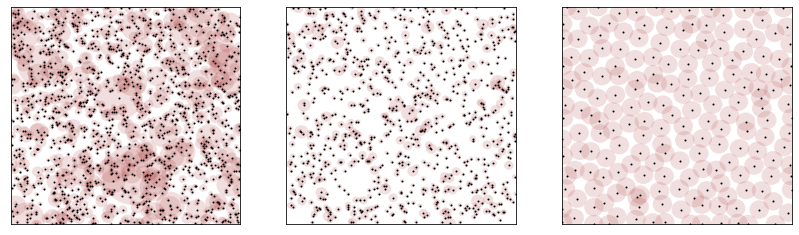

In [27]:
fig, ax = plt.subplots(figsize=(14,4), ncols=3, sharex=True, sharey=True)
ax = ax[::-1]

load_pickle('cache/spacing_with_Abar_no_growth.p')
allxy = xy
xy = vstack(allxy[AbarRange[-1]][areaDeathRateRange[-1]][0])
data.plot(xy, [8.5]*len(xy), 200, ax=ax[0], show_center=True,
          plot_kw={'xticks':[],'yticks':[]});

load_pickle('plotting/biomass_scaling_w_compet_nu=2.0.p')
forest[basalRange[0]].plot(ax=ax[1],
                           show_canopy=False,
                           show_center=True,
                           plot_kw={'xticks':[], 'yticks':[]})

forest[basalRange[2]].plot(ax=ax[2],
                           show_canopy=False,
                           show_center=True,
                           plot_kw={'xticks':[], 'yticks':[]})

fig.subplots_adjust(wspace=.2)
fig.savefig(f'{imgdr}/spacing_examples.pdf', bbox_inches='tight')

# Figure 4

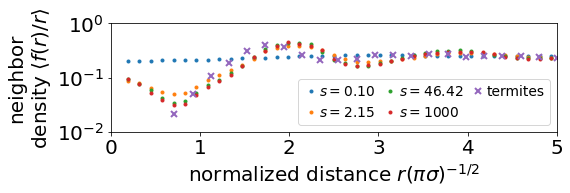

In [86]:
load_pickle('cache/packing_example.p')
load_pickle('plotting/spatial_correlation.p')

fig, ax = plt.subplots(figsize=(8,2))

for p_ in list(p.values())[::3]:
    # spatial autocorrelation function
    ax.semilogy(r, p_/r, '.')
    
namp, namr = data.namibia_corr_fcn()
drRatio = (namr[1]-namr[0]) / (r[1]-r[0])
ax.plot(namr, namp/namr / drRatio, 'x', mew=2)
    
ax.set(xlim=(0,5), yscale='log',
       xlabel=r"normalized distance $r(\pi\sigma)^{-1/2}$", ylabel='neighbor\n'+r"density $\langle f(r)/r\rangle$")
ax.set(ylim=(1e-2,1), yticks=[1e-2,.1,1])
ax.legend([r'$s=%1.2f$'%i for i in areaDeathRateRange[::3]][:-1]+[r'$s=1000$']+['termites'],
          ncol=3, fontsize='x-small', columnspacing=.6, handletextpad=.09, handlelength=1)

fig.savefig(f'{imgdr}/spatial_corr.pdf', bbox_inches='tight')

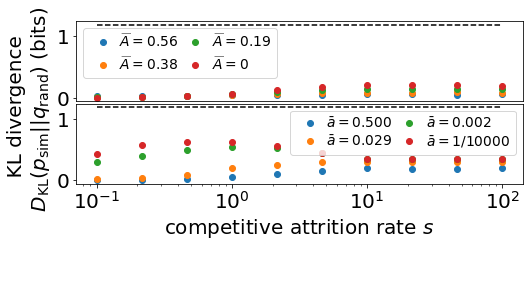

In [87]:
fig, ax = plt.subplots(figsize=(8,3), nrows=2, sharey=True,
                       gridspec_kw={'hspace':0.03})

load_pickle('plotting/dkl_Abar_range.p')
for kl_ in kl[1:]:
    ax[0].semilogx(areaDeathRateRange, kl_, 'o')
    
load_pickle('plotting/dkl_cg_range.p')
for kl_ in kl:
    ax[1].semilogx(areaDeathRateRange, kl_, 'o')

ax[0].hlines(1.19, areaDeathRateRange.min(), areaDeathRateRange.max(),
             linestyles='--')
ax[1].hlines(1.19, areaDeathRateRange.min(), areaDeathRateRange.max(),
             linestyles='--')

ax[1].set(xlabel=r'competitive attrition rate $s$',
          ylabel='            KL divergence\n'r'           $D_{\rm KL}(p_{\rm sim}||q_{\rm rand})$ (bits)')
# ax[0].xaxis.set_tick_params(length=0)
ax[0].set(xticks=[])
ax[0].xaxis.set_ticks_position('none')
ax[1].set(ylim=ax[0].get_ylim())
ax[0].legend([r'$\widebar A=%1.2f$'%a for a in AbarRange[1:-1]]+[r'$\widebar{A}=0$'],
             fontsize='x-small', handletextpad=.2, ncol=2, loc=2, columnspacing=.2)
ax[1].legend([r'$\bar{a}=%1.3f$'%a for a in cgRange[:-1]]+[r'$\bar{a}=1/10000$'],
             fontsize='x-small', handletextpad=.2, ncol=2, loc=1, columnspacing=.2, labelspacing=.2)

fig.savefig(f'{imgdr}/dkl.pdf', bbox_inches='tight')

[[<matplotlib.axis.YTick at 0x7f235e7aaac0>,

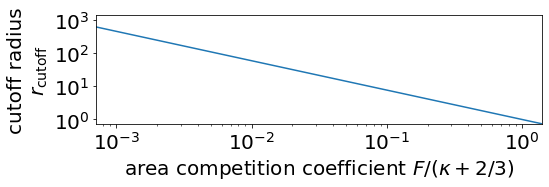

In [572]:
fig, ax = plt.subplots(figsize=(8,2))

coeff = logspace(-4,1.1,10)
delta = 1.8 - 4/3

ax.loglog(coeff, coeff**(-1/(delta+2/3)), '-')

ax.set(xlabel=r'area competition coefficient $F/(\kappa+2/3)$',
       ylabel='cutoff radius\n'r'$r_{\rm cutoff}$',
       xlim=(0.000707945784384138, 1.4125375446227544),
       ylim=(0.7373047958716826, 1e3/0.7373047958716826))
ax.set(yticks=[1,10,100,1000])

fig.savefig(f'{imgdr}/cutoff_scaling.pdf', bbox_inches='tight')

# Figure 5

Text(0.825, 0.395, 'B')

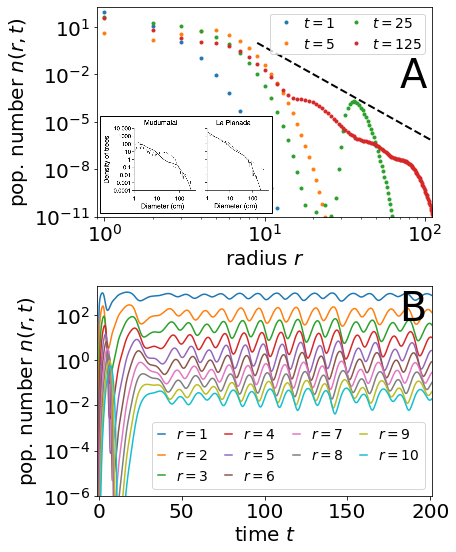

In [88]:
fig, ax = plt.subplots(figsize=(6,9), nrows=2,
                       gridspec_kw={'hspace':.33})

tplot = [1, 5, 25, 125]
y = pd.read_csv('../mathematica/nk_oscillations.csv')
for i, t in enumerate(tplot):
    ax[0].plot(y.columns, y.iloc[i], '.')
x = array([9, 200])
y = x**(-6+1/3)
y *= 1 / y[0]
ax[0].loglog(x, y, 'k--', lw=2)

ax[0].set(xscale='log', yscale='log',
       xlabel=r'radius $r$', ylabel=r'pop. number $n(r,t)$')
ax[0].set(xlim=(.9, 100/.9), ylim=(1e-11, 2e2))
ax[0].legend([r'$t=%d$'%i for i in tplot],
             fontsize='x-small',
             ncol=2,
             handletextpad=.2,
             borderpad=.2,
             columnspacing=.5,
             loc=1)

forestex = imread('../writing/20200723_dynamics_draft/wave_example.png')
imagebox = OffsetImage(forestex, zoom=.11)
ab = AnnotationBbox(imagebox, (3.25, 2e-8), pad=.1)
ax[0].add_artist(ab)

y = pd.read_csv('../mathematica/curves.csv')
x = array(y.columns.values).astype(float)
for i in range(10):
    ax[1].semilogy(x, y.iloc[i], '-')
ax[1].set(ylim=(1e-6, 2e3), xlim=(-1,201),
          xlabel=r'time $t$', ylabel=r'pop. number $n(r,t)$')
ax[1].legend([r'$r=%d$'%r for r in range(1,11)],
             fontsize='x-small', handlelength=.5, ncol=4, columnspacing=1.2)

fig.text(.825, .755, 'A', fontsize='40')
fig.text(.825, .395, 'B', fontsize='40')

fig.savefig(f'{imgdr}/pop_waves.pdf', bbox_inches='tight', dpi=200)

# Supplementary figures

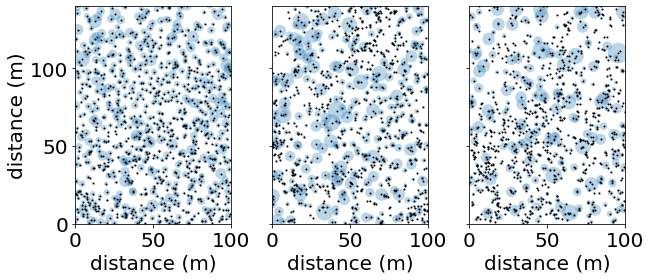

In [56]:
def forest_plot(plotNo, ax):
    df = pd.read_csv('../data/uas/southeast_alaska/Data/Data.csv')

    ix = df['Plot ']==plotNo  # select a patch
    x, y = df['Xcoord.m'].loc[ix], df['Ycoord.m'].loc[ix]
    r = df['DBH.cm'].loc[ix] / 100 * 5

    # there are some weird outliers that must something wrong
    badix = (x<0) | (x>100)
    x = x[~badix]
    y = y[~badix]
    r = r[~badix]

    # create patches for plotting
    p = []
    for x_, y_, r_ in zip(x, y, r):
        p.append(Circle((x_,y_), r_))
        
    patches = PatchCollection(p, alpha=.3)
    
    ax.plot(x, y, 'k.', ms=2)
    ax.add_collection(patches)

fig, ax = plt.subplots(figsize=(10,4), ncols=3, sharex=True, sharey=True)
ax = ax.ravel()

forest_plot(32, ax[0])
forest_plot(76, ax[1])
forest_plot(130, ax[2])

ax[-1].set(xlim=(0,100), ylim=(0,140))
ax[0].set(ylabel='distance (m)')
for a in ax:
    a.set_aspect('equal')
    a.set(xlabel='distance (m)')

fig.savefig(f'{imgdr}/alaskan_forest.pdf', bbox_inches='tight')

#### Puerto Rico rainfall

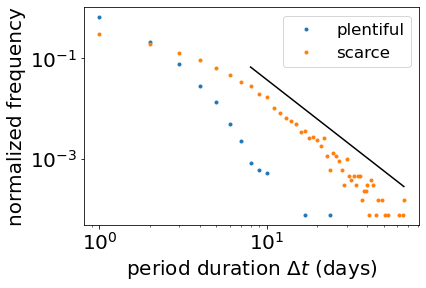

In [57]:
load_pickle('plotting/pr_rainfall.p')

abovedt = np.concatenate(list(abovedt.values()))
belowdt = np.concatenate(list(belowdt.values()))

fig, ax = plt.subplots()

na = bincount(abovedt)[1:]
xa = arange(1, na.size+1)

nb = bincount(belowdt)[1:]
xb = arange(1, nb.size+1)
    
na = na / na.sum()
nb = nb / nb.sum()

# data
ax.loglog(xa, na, '.', c='C0')
ax.loglog(xb, nb, '.', c='C1')

# power law comparison
x = array([8, xb[-1]])
ax.loglog(x, 15 * x**-2.6, 'k-')

ax.set(xlabel=r'period duration $\Delta t$ (days)', ylabel='normalized frequency')
ax.legend(('plentiful', 'scarce'), fontsize='small')

fig.savefig(f'{imgdr}/pr_rainfall.pdf', bbox_inches='tight')

#### Automaton solution to WEB model

<ipython-input-37-4431144a3497>:43: RuntimeWarning: invalid value encountered in double_scalars
  lognk[k] = np.array([nk_[ix==i].sum() / (ix==i).sum() for i in range(ix.max()+1)])


[None, None, None, None, None, None, None]

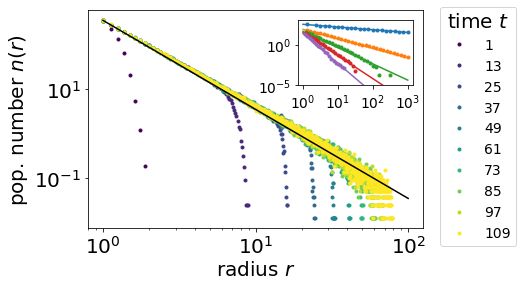

In [37]:
load_pickle('cache/linear_model_exponent_transience.p')

rk = rk[0]
nk = np.concatenate([i[:,:,None] for i in nk], axis=2)
nk = nk.mean(2)
tRange = range(1, 112, 12)

fig, ax = plt.subplots()

h = []
cmap = colorcycle(10)
for i in tRange:
    h.append(ax.loglog(rk, nk[i], '.', c=next(cmap))[0])

dx = (rk[1]-rk[0])
y = rk**(-1/3 -cm/cg)
y *= g0 / (cg / dx * rk[0]**(2/3) + cm * rk[0]**(-2/3)) / y[0]
ix = rk<100
h.append(ax.loglog(rk[ix], y[ix], 'k-')[0])

ax.set(xlabel=r'radius $r$', ylabel=r'pop. number $n(r)$',
       xlim=(.8, 100/.8))
leg = ax.legend(h, tRange, title=r'time $t$',
                bbox_to_anchor=(1.3,1.05),
                loc=1,
                fontsize='x-small')



load_pickle('cache/linear_model_exponent.p')

# create log bins
nbins = arange(5) * 6 + 25
lognk, logrk, dx = {}, {}, {}

counter = 0
for (k, nk_), rk_ in zip(nk.items(), rk.values()):
    nk_ = nk_[-200:].mean(0)
    
    ix = np.digitize(rk_, np.logspace(0, np.log10(rk_[-1]), nbins[counter]))
    
    logrk[k] = np.logspace(0, np.log10(rk_[-1]), nbins[counter])
    lognk[k] = np.array([nk_[ix==i].sum() / (ix==i).sum() for i in range(ix.max()+1)])
    dx[k] = rk_[1] - rk_[0]
    
    counter += 1

axins = inset_axes(ax, width=1.6, height=.9)
h = []

for i, (cm, rk_, nk_, dx_) in enumerate(zip(cmRange, logrk.values(), lognk.values(), dx.values())):
    h.append(axins.loglog(rk_, nk_[:-1], '.')[0])
    
    # match up slope prediction to last point
    exponent = 1/3 + cm / cg
    y = rk_**(-exponent)
    y *= g0 / (cg / dx_ + cm) / y[0]
    h.append(axins.loglog(rk_, y, '-', c=f'C{i}')[0])

axins.set(ylim=(1e-5, 1e3), xticks=(1,10,100,1e3))
[el.set_fontsize('x-small') for el in axins.xaxis.get_ticklabels()]
[el.set_fontsize('x-small') for el in axins.yaxis.get_ticklabels()]

fig.savefig(f'{imgdr}/indpt_model.pdf', bbox_inches='tight')

#### KL divergence for solid phase

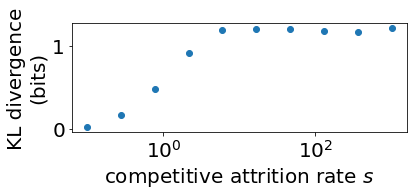

In [58]:
load_pickle('cache/packing_example.p')

kl = np.zeros_like(areaDeathRateRange)
interpkl = zeros_like(areaDeathRateRange)
optbinWidth = zeros_like(areaDeathRateRange)

for j, adr in list(enumerate(areaDeathRateRange)):
    dr = concatenate([nn.dist(xy_) for xy_ in xy[adr]])
    N = mean([len(xy_) for xy_ in xy[adr]])
    
    # interpolate DKL curve to extrapolate value
    bins = logspace(log10(dr.max()/dr.size)+2, log10(dr.max()/dr.size)+5, 30)
    d = zeros_like(bins)
    for k in range(d.size):
        d[k] = nn.kl(dr, N, L, bins[k])
    optbinWidth[j] = bins[argmin(d)]
    
    kl[j] = nn.kl(dr, N, L, optbinWidth[j])

fig, ax = plt.subplots(figsize=(6,2))
ax.semilogx(areaDeathRateRange, kl, 'o')

ax.set(xlabel=r'competitive attrition rate $s$',
       ylabel='KL divergence\n(bits)')
fig.savefig(f'{imgdr}/dkl_ordering.pdf', bbox_inches='tight')

#### Examples of phase regions

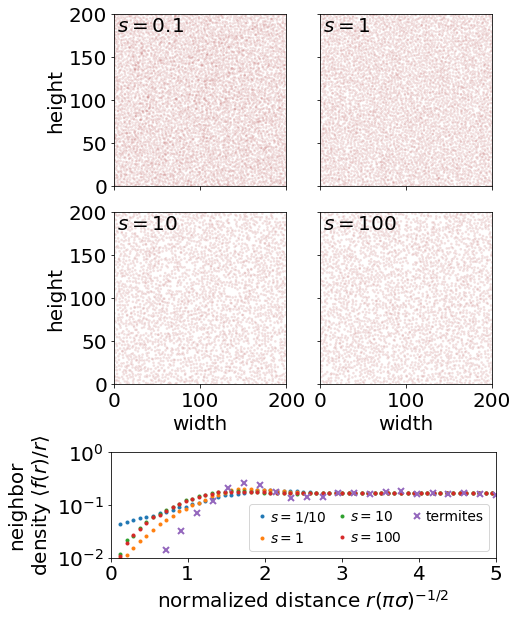

In [48]:
load_pickle('cache/spacing_with_cg.p')

allxy = xy

fig = plt.figure(figsize=(6.9,10))
gs = GridSpec(3, 2, wspace=.1, hspace=.5, height_ratios=(1,1,.7))
gsSub = GridSpecFromSubplotSpec(2,2, gs[:2,:], wspace=.15, hspace=.15)
ax = (fig.add_subplot(gsSub[0,0], aspect='equal'),
      fig.add_subplot(gsSub[0,1], aspect='equal'),
      fig.add_subplot(gsSub[1,0], aspect='equal'),
      fig.add_subplot(gsSub[1,1], aspect='equal'))

xy = vstack(allxy[cgRange[-1]][areaDeathRateRange[0]][0])
data.plot(xy, [1.5]*len(xy), 200, ax=ax[0])
ax[0].text(3, 180, r'$s=0.1$')

xy = vstack(allxy[cgRange[-1]][areaDeathRateRange[3]][0])
data.plot(xy, [1.5]*len(xy), 200, ax=ax[1])
ax[1].text(3, 180, r'$s=1$')

xy = vstack(allxy[cgRange[-1]][areaDeathRateRange[6]][0])
data.plot(xy, [1.5]*len(xy), 200, ax=ax[2])
ax[2].text(3, 180, r'$s=10$')

xy = vstack(allxy[cgRange[-1]][areaDeathRateRange[9]][0])
data.plot(xy, [1.5]*len(xy), 200, ax=ax[3])
ax[3].text(3, 180, r'$s=100$')

ax[0].set(xticklabels=[], ylabel='height')
ax[1].set(xticklabels=[], yticklabels=[])
ax[2].set(xlabel='width', ylabel='height')
ax[3].set(yticklabels=[], xlabel='width')


load_pickle('plotting/spatial_corr_liquid.p')
ax = fig.add_subplot(gs[2,:])

for p_ in list(p.values())[::3]:
    # spatial autocorrelation function
    ax.semilogy(r, p_/r, '.')
    
namp, namr = data.namibia_corr_fcn()
drRatio = (namr[1]-namr[0]) / (r[1]-r[0])
ax.plot(namr, namp/namr / drRatio, 'x', mew=2)
    
ax.set(xlim=(0,5), yscale='log',
       xlabel=r"normalized distance $r(\pi\sigma)^{-1/2}$", ylabel='neighbor\n'+r"density $\langle f(r)/r\rangle$")
ax.set(ylim=(1e-2,1), yticks=[1e-2,.1,1])
ax.legend([r'$s=1/10$',r'$s=1$',r'$s=10$',r'$s=100$']+['termites'],
          ncol=3, fontsize='x-small', columnspacing=.6, handletextpad=.09, handlelength=1, loc=4)

fig.savefig(f'{imgdr}/liquid_phase.pdf', bbox_inches='tight')

#### Canopy simulation example

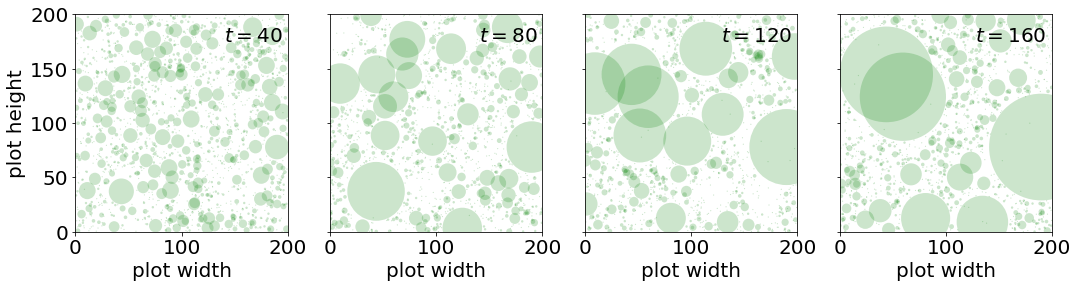

In [396]:
load_pickle('plotting/oscillation_plot_examples.p')

fig, ax = plt.subplots(figsize=(17.5,4), ncols=4)
for i, (k, t) in enumerate(trees.items()):
    forest.plot(all_trees=t, ax=ax[i])
    ax[i].text(195, 175, r'$t=%d$'%k, ha='right')
    if i>0: ax[i].set(yticklabels=[])
    else: ax[i].set(ylabel='plot height')
    ax[i].set(xlabel='plot width')
    
fig.savefig(f'{imgdr}/oscillation_plots.pdf', bbox_inches='tight')

#### Non-power-law growth (logistic) example

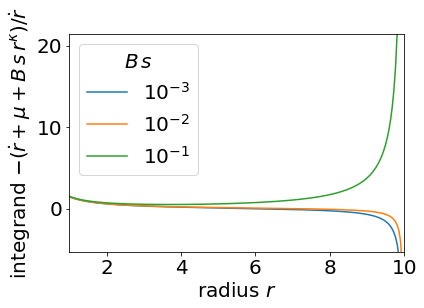

In [44]:
r0 = 1
rmax = 10
a = 1
thalf = 5
lam = 1
mu0 = 1
kappa = 2

rdot = lambda r: rmax * a / 2 * cosh(arctanh(2 * r / rmax - 1))**-2
drdot = lambda r: -2 * a * (2*r / rmax - 1)
mu = lambda r: mu0 * r**(-2/3)

bsrange = np.logspace(-3, -1, 3)
rRange = np.linspace(r0, rmax-.05, 200)

fig, ax = plt.subplots()

for bs in bsrange:
    ax.plot(rRange, (drdot(rRange) + mu(rRange) + bs * rRange**kappa)/rdot(rRange))
    
ax.set(xlabel=r'radius $r$', ylabel='integrand $-(\dot{r}+\mu+ B\,s\,r^\kappa)/\dot{r}$',
       xlim=(r0, rmax), ylim=(-5.308656142979472, 21.37184385702066))
ax.legend((r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$'), title=r'$B\,s$')

fig.savefig(f'{imgdr}/pop_tail.pdf', bbox_inches='tight')

#### Automaton simulation of asymmetric competition

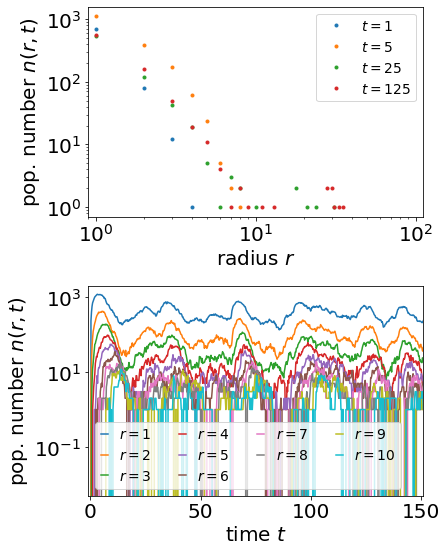

In [53]:
load_pickle('cache/automaton_oscillation_example.p')

# average across forests (this averages out random fluctuations)
# thisnk = concatenate([i[:,:,None] for i in nk], axis=2).mean(2)
# show a single forest
thisnk = nk[1]

fig, ax = plt.subplots(figsize=(6,9), nrows=2,
                       gridspec_kw={'hspace':.33})

for thist in [1, 5, 25, 125]:
    i = argmin((thist-t[0])**2)
    ax[0].loglog(forest.rRange, thisnk[i], '.')
ax[0].set(xlabel=r'radius $r$', ylabel=r'pop. number $n(r,t)$',
          xlim=(.9,100/.9))
ax[0].legend([r'$t=1$', r'$t=5$', r'$t=25$', r'$t=125$'], fontsize='x-small')
    
for i in range(10):
    ax[1].plot(t[0], thisnk[:,i])
    
ax[1].set(xlabel=r'time $t$', ylabel=r'pop. number $n(r,t)$',
          yscale='log', ylim=(1e-2/2, 2e3), xlim=(-1,151))
ax[1].legend([r'$r=%d$'%r for r in range(1,11)],
             fontsize='x-small', handlelength=.5, ncol=4)

fig.savefig(f'{imgdr}/2d_pop_waves.pdf', bbox_inches='tight')

#### Spatial distribution comparison with termites

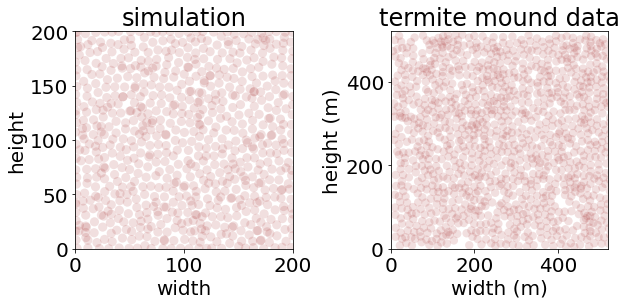

In [295]:
df = pd.read_csv('../data/Tarnita/termite_mound_location_field_data/Namib_G1.txt',
                 sep='\t',
                 header=None)
termitexy = df.values

load_pickle('cache/packing_example.p')

allxy = xy
xy = vstack(allxy[areaDeathRateRange[-1]][0])

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121, aspect='equal'), fig.add_subplot(122, aspect='equal')

data.plot(xy, [4.2]*len(xy), 200, ax=ax[0])
data.plot(termitexy, [10]*len(termitexy), 520, ax=ax[1])

ax[0].set(title='simulation', xlabel='width', ylabel='height')
ax[1].set(title='termite mound data', xlabel='width (m)', ylabel='height (m)')

fig.subplots_adjust(wspace=.3)
fig.savefig(f'{imgdr}/termite_mounds.pdf', bbox_inches='tight')